### This assignment may be worked individually or in pairs. 
### Enter your name/names here:

In [2]:
# Manojwal Oddiraju

In [3]:
# headers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assignment 3: Linear Regression and KNN Classifier

## Part 1: Linear regression with scikit-learn

In this part of the assignment, you will fit a linear regression model to an insurance dataset using the scikit-learn package. 

The insurance company would like to be able to estimate the annual medical expenditures they will need to pay for any customer, based on the customer's age, sex, BMI, # of children, whether they are a smoker, and their region of residence. 

Estimates from this model can be used to then determine how much to charge each customer for insurance (the more we think you'll cost us, the more we will charge you).

**Data Prep**

Q1. Read the dataset from 'medical-charges.txt' into a Pandas Dataframe. Display the head of the dataset. There should be 1338 rows and 7 columns. The target column (y) is the `charges` column.

In [4]:
med_charges = pd.read_csv("medical-charges.txt")
med_charges.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Q2. Notice that there are several categorical columns. You'll need to transform these to be able to do regression. Since `sex` and `smoker` are binary in this dataset, let's do them differently than `region` which has 4 options.

* Use the Pandas [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function to one-hot-encode `sex` and `smoker`. 
* Since these features are binary, we do not need to create two columns for each of them (i.e. we do not need both smoker_yes and smoker_no - just having a smoker_yes column will be sufficient), so use the `drop_first` parameter of get_dummies to create only a `smoker_yes` and a `sex_male` column. 
* Display the head of the dataframe.

In [5]:
med_charges = pd.get_dummies(med_charges, columns=["sex", "smoker"], drop_first=True)
med_charges.head()

,age,bmi,children,region,charges,sex_male,smoker_yes
0,19,27.900,0,southwest,16884.92400,False,True
1,18,33.770,1,southeast,1725.55230,True,False
2,28,33.000,3,southeast,4449.46200,True,False
3,33,22.705,0,northwest,21984.47061,True,False
4,32,28.880,0,northwest,3866.85520,True,False


Q3. Now one-hot encode the `region` feature by again using `get_dummies()`, but this time, even though we could drop one column, let's go ahead and explicitly keep all 4 values as columns (i.e. drop_first should be set to False). Display the head of the resulting dataframe.

In [6]:
med_charges = pd.get_dummies(med_charges, columns=["region"], drop_first=False)
med_charges.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,False,True
1,18,33.770,1,1725.55230,True,False,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,False,True,False
3,33,22.705,0,21984.47061,True,False,False,True,False,False
4,32,28.880,0,3866.85520,True,False,False,True,False,False


Q4. An interesting thing to check with regression problems is whether any of the individual features correlate very strongly with the target. Use the `corr()` method on the dataframe to take a look at this.

Answer as a comment: Do you see any features with a strong correlation to the target?

In [7]:
target_corr = med_charges.corr()["charges"]
print(target_corr)

# no surprise, smoker is a very strong correlation with .78, and age is the next strongest at .299. This of course is entirely expected since smokers tend to be in worse health.

age                 0.299008
bmi                 0.198341
children            0.067998
charges             1.000000
sex_male            0.057292
smoker_yes          0.787251
region_northeast    0.006349
region_northwest   -0.039905
region_southeast    0.073982
region_southwest   -0.043210
Name: charges, dtype: float64


Q5. Create a plot to show the difference in charges between the smokers and the non-smokers. 

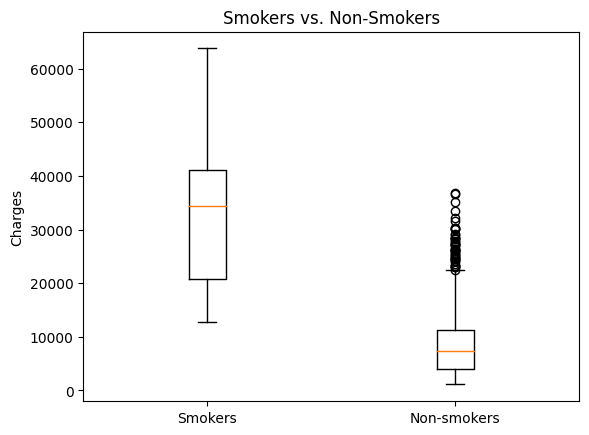

In [8]:
smokers = med_charges[med_charges["smoker_yes"] == True]
non_smokers = med_charges[med_charges["smoker_yes"] == False]
plot_data = [smokers["charges"], non_smokers["charges"]]
plt.boxplot(plot_data, labels=["Smokers", "Non-smokers"])
plt.ylabel("Charges")
plt.title("Smokers vs. Non-Smokers")
plt.show()


Q6. Let's explore the relationship between `age` and `charges`. Create a scatter plot of all data points to show age vs charges. 

Answer as a comment: What do you notice about the nature of this relationship?

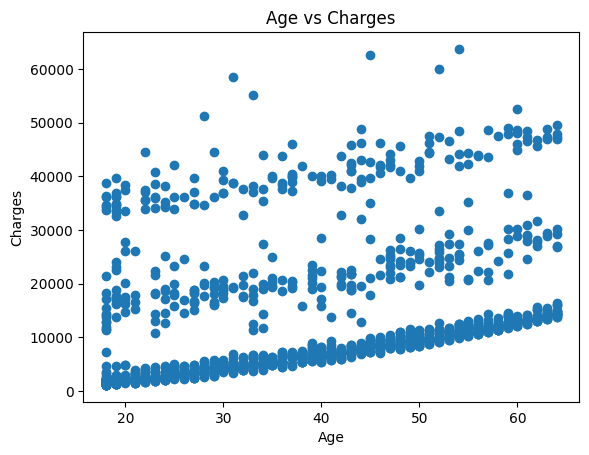

In [9]:
age = med_charges["age"]
plt.scatter(age, med_charges["charges"])
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Age vs Charges")
plt.show()

# generally as you get older, you charge the insurance company more, but there are outliers at every single age.
# This is most likely individuals with conditions/accidents.


#### Simple Linear Regression
**Fit a simple linear regression model to predict `charges` from `age`.**

Q7. 
* Grab the `age` column from the dataframe and call it something like `x`.
* Grab the `charges` column from the dataframe and call it something like `y`.
* When doing simple linear regression (one feature), you need to convert the features from a Series to an array of arrays. You can do this by doing `x = x.values.reshape(-1,1)`, where the (-1,1) means (all rows, one column). 
* Do the same to the labels (`y = y.values.reshape(-1,1)`). 
* Verify that you have an array of arrays for both x and y. (It should be using `numpy.ndarray` by default.)

In [10]:
x = med_charges["age"]
y = med_charges["charges"]
x = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1338, 1)
(1338, 1)


**Using the holdout method to evaluate**

Q8. Use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split your dataset into training and test sets. Do an 80%-20% split. Display how many records are in the training set and how many are in the test set. Set the `random_state` argument to your favorite number.

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=45)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

1070
268
1070
268


Q9. Fit a simple linear regression model to the x and y data. This computes the B0 and B1 coefficients.
* Create a [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object. 
* Call `fit` on it and pass in the training set.
* Print the slope and the intercept of the equation with the `.coef_` and `.intercept_` attributes. 

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print(lin_reg.coef_)
print(lin_reg.intercept_)

[[255.82312457]]
[3373.12368249]


Q10. Now that you've fit the model on the training set, you can evaluate it on the test set. Call `predict` on the linear regression object and pass in the test set. Save the return value - these are all of the predicted values under the model for the test set. 

Compute some metrics to see how well this model fits the test data. Use `sklearn.metrics` to print out the MAE, MSE, RMSE, and R2 for the test set under this model. Remember that you have the actual y values for your test set, up in Q8.  

In [13]:
import sklearn.metrics as metrics
y_predicted = lin_reg.predict(x_test)
mae = metrics.mean_absolute_error(y_test, y_predicted)
mse = metrics.mean_squared_error(y_test, y_predicted)
rmse = metrics.root_mean_squared_error(y_test, y_predicted)
r2 = metrics.r2_score(y_test, y_predicted)
print(mae, mse, rmse, r2)

8545.119868302234 116281233.25392485 10783.37763661854 0.10150400248747538


Q11. Let's see what the best fit line looks like with the test data. Scatter-plot the test data (x_test, y_test). Then line-plot the model predictions for the test data (x_test, y_test_preds). 

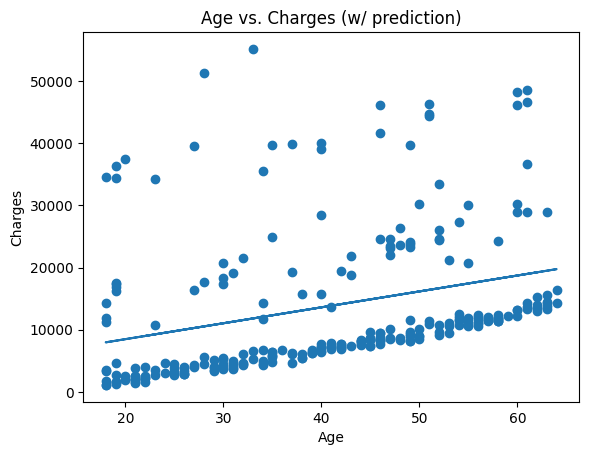

In [14]:
plt.scatter(x_test, y_test)
plt.plot(x_test, y_predicted)
plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Age vs. Charges (w/ prediction)")
plt.show()


Q12. Now, go back up to your Q8, change the random_state to a different number, and re-run Q9, Q10, Q11. 

Answer as a comment: What happened and why?

In [15]:
# The line moved a little bit, and the data corr_coeff almost doubled (I changed rand_state from 11 to 23, r^2 went from .06 to .12)
# A different data set was generated for test and for training, it is possible the training data set aligns more with
# the test data now, which is why all my errors decreased and my corr_coeff nearly doubled.
# I tested this again by changing the number from 23 to 45, and now the corr_coeff decreased as I guess this generation set
# has a training and test set that do not align with each other as well

**Using cross-validation to evaluate**

Q13. We've discussed and seen the issues that can happen when we do a single hold-out test set. Cross validation is a better, more robust way to evaluate our models. Use `sklearn.model_selection.cross_val_score` to perform 5-fold cross validation on a simple linear regression model. 

You will pass the FULL dataset (x and y from before the train/test split in Q8) into `cross_val_score` which will automatically divide it into the number of folds you tell it to, fit a linear regression model to the training set for each fold, and test it on the test set for each fold. It will return a numpy array with the R2 on the test set for each fold. Average these R2 scores to print out the generalization estimate of the model.

On average, after 5 trials with 5 different test sets, this is how well we think a linear regression of using `age` to predict `charges` will work. 

In [16]:
from sklearn.model_selection import cross_val_score
performance = cross_val_score(lin_reg, x, y, cv=5, scoring="r2")
avg_r2 = np.mean(performance)
print(avg_r2)

0.08821241573294034


#### Multiple Linear Regression
**Fit a multiple linear regression model to predict `charges` from more than one feature.**

Q14. Now let's see if we can get a better model by including another feature.
* From the one-hot-encoded dataframe (the result of Q3), grab both the `age` and `smoker_yes` columns. Call it something like x. 
* (No need to call a reshape this time, since it is multi-dimensional data now.)
* You already have the y's.
* Create a new `sklearn.linear_model.LinearRegression` object. (Or you can re-use the one you already have.)
* Pass it all into a `sklearn.model_selection.cross_val_score` with a 5-fold CV.
* Print out the average R2.

Answer as a comment: What happens when you include `smoker_yes`?

In [17]:
x = med_charges[["age", "smoker_yes"]]
new_reg = LinearRegression()
new_performance = cross_val_score(new_reg, x, y, cv=5, scoring="r2")
new_avg_r2 = np.mean(new_performance)
print(new_avg_r2)

# Including smoker_yes significantly improves the accuracy of the model (almost tenfold)
# No suprises here, the corr() function returned a strong relation between smoking and the charges by a consumer


0.7191692504028052


Q15. Let's go one more step and see if including ALL of our features is even better at predicting the `charges` than using just `age` and `smoker`.

* From the one-hot-encoded dataframe (the result of Q3), grab all the features, but NOT the target. Call it something like x.
* (No need to call a reshape this time, since it is multi-dimensional data now.)
* You already have the y's.
* Create a new sklearn.linear_model.LinearRegression object. (Or you can re-use the one you already have.)
* Pass it all into a sklearn.model_selection.cross_val_score with a 5-fold CV.
* Print out the average R2.

Answer as a comment: What happens when you use ALL of the features?

In [18]:
x = med_charges.drop(columns=["charges"])
newer_reg = LinearRegression()
newer_perf = cross_val_score(newer_reg, x, y, cv=5, scoring="r2")
newer_avg_r2 = np.mean(newer_perf)
print(newer_avg_r2)

# Model accuracy increases a little bit more when we use all the features, but not nearly as much as the jump between just age and age + smokers.

0.746861624347374


Q16. Build the final model on the entire dataset. 
* You should already have your x from the previous question (Q15).
* You already have the y's.
* Create a new `sklearn.linear_model.LinearRegression` object, or you can re-use the one you already have.
* Call `fit` and pass in all the data (x, y).
* Print out the coefficients and the intercept of the fitted model. The coefficients correspond to the the order in which the features are in the dataframe (x).

This defines your multiple linear regression equation! 

In [19]:
final_reg = LinearRegression()
final_reg.fit(x, y)
print(f"Final coefs: {final_reg.coef_}")
print(f"Final intercept: {final_reg.intercept_}")

Final coefs: [[  256.85635254   339.19345361   475.50054515  -131.3143594
  23848.53454191   587.00923503   234.0453356   -448.01281436
   -373.04175627]]
Final intercept: [-12525.5478112]


#### Regularization / Hyperparameter tuning to prevent overfitting
**Use a Ridge Regression model to predict `charges`. Tune the penalty strength (lambda) to avoid both over and under fitting.**

Q17. Now let's look at a model that includes a regularization hyperparameter to control for over and under fitting. 

* Data must be scaled for Ridge Regularization because of the L2 penalty term. Use `sklearn.preprocessing.StandardScaler` to scale the x data (`fit_transform`).
* **NOTE:** Typically you should not scale the entire dataset upfront like this! Scaling should be done inside the cross validation loop to avoid data leakage! But for simplicity's sake on this assignment, go ahead and scale the data upfront here. On the next assignment, you'll see how to put the scaling inside of the cross validation loop.
  
* The `sklearn.linear_model.Ridge` package uses `alpha` as the regularization strength parameter (I referred to this as **lambda** in class.) Create two new `sklearn.linear_model.Ridge` objects. Set the alpha of one of them to 5 and set the alpha of the other one to 50.
* Use `cross_val_score` to evaluate both models and print out their average R2.
* Answer as a comment: How do these two models compare? What happens as lambda gets higher and why?


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
r5 = Ridge(5)
r50 = Ridge(50)

r2_ridge5 = cross_val_score(r5, x_scaled, y, cv=5, scoring="r2")
r2_ridge50 = cross_val_score(r50, x_scaled, y, cv=5, scoring="r2")

avg_r2_r5 = np.mean(r2_ridge5)
avg_r2_r50 = np.mean(r2_ridge50)

print(f"Ridge alpha 5: {avg_r2_r5}")
print(f"Ridge alpha 50: {avg_r2_r50}")

# As you crank alpha up, the regularization becomes stronger. 50 seems to be too high as the data starts becoming underfit by a tiny bit (small decrease in r2).

Ridge alpha 5: 0.7468814115344922
Ridge alpha 50: 0.7456619076114526


Q18. Let's see how we can tune alpha (lambda) with cross validation. 

Inner cross validation loop / hyperparameter tuning:

* Create a new `sklearn.linear_model.Ridge` object. Do not set alpha.
* I have created a "parameter grid" (`param_grid`) for you. This is simply a list of values that you want to try setting the hyperparameter (`alpha`) to. You'll see that it includes some values less than 1 and some values greater than 1. This is good range for hyperparameter tuning in Ridge Regression because it ensures that tested alpha/lambda values cover a wide range, from very small (little regularization) to very large (strong regularization), allowing the model to find an optimal balance between under and over fitting.
* For the hyperparameter tuning cross validation loop, we'll use `sklearn.model_selection.GridSearchCV` (an alternative to this would be `sklearn.model_selection.RandomizedSearchCV`.) Create a `sklearn.model_selection.GridSearchCV` object, setting the estimator to your `Ridge` object, param_grid to the param_grid that is provided for you, and the number of CV folds to 5.

Outer cross validation loop / evaluation:

* Use `sklearn.model_selection.cross_val_score` with 5 folds for the outer cross validation loop. Pass into it the `GridSearchCV` you just created, the data (x), and the targets (y).

What this does is: The cross_val_score splits the data in to train and test sets for the first outer fold, and it passes the train set into GridSearchCV. GridSearchCV then splits that set into train and validation sets for k number of folds (the inner CV loop). The hyper-parameters for which the average score over all inner iterations is best, is reported as the best_params_, best_score_, and best_estimator_(best regression coefficients). This best model is then evaluated with the test set from the cross_val_score (the outer CV loop). And this whole thing is repeated for the remaining k folds of the cross_val_score (the outer CV loop).

This is the entire, very complex, very IMPORTANT, nested cross validation process happening within a single line of code!

* Print out the average R2 over the 5 outer CV folds.
* Answer as a comment: How does the Ridge Regression model compare to the ordinary Least Squares model on this data? 

In [21]:
# Define hyperparameter grid
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 1, 5, 10, 15]}
new_ridge = Ridge()
grid_search = GridSearchCV(new_ridge, param_grid, cv=5)
ridge_final_r2 = cross_val_score(grid_search, x_scaled, y, cv=5, scoring="r2")

print(np.mean(ridge_final_r2))

# The r2 is slightly smaller when compared to the LinReg, but I'm assuming that the Ridge Regression is better at avoiding overfitting to high correlation features

0.7468329164665739


## ---------------------------------------- 
## Part 2: K-Nearest Neighbors from scratch

In this part of the assignment you'll implement the K-Nearest Neighbors (KNN) classification algorithm to classify patients as either having or not having diabetic retinopathy. For this task we'll be using the same Diabetic Retinopathy data set which was used in the previous assignment on decision trees. 

You may use the following function to print a confusion matrix:

In [22]:
def print_confusion_matrix(TP, FN, FP, TN):
    
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted 1','Predicted 0'])
    df = df.rename(index={0: 'Actual 1', 1: 'Actual 0'})
    display(df)

In [23]:
# you may use these constants if you want
LABEL_COLUMN = 19
BINARY_COLUMNS = {0,1,18}

Q1. Normalize the data so that each feature value lies between `[0-1]`.

In class, we talked about why scaling the data is critical to KNN. We also talked about how data scaling should be done *inside the cross validataion loop*. This means that the scaling parameters should be based on the **training set only**, in order to prevent data leakage. Then the test data will need to be scaled, using the parameters found on the **training** data.

Fill in the function to take in a training dataset and a test dataset and normalize them correctly. Return the normalized datasets.

Caution: Return NEW datasets that have been normalized - do not normalize the datasets in-place, so that this can be run numerous times without altering the original data or normalizing already normalized data.

Hint: When using dataframes, you can do this without a loop!

In [24]:
def normalize_data(train, test):
    train_min = train.min()
    train_max = train.max()
    train_norm = (train - train_min) / (train_max - train_min)
    test_norm = (test - train_min) / (train_max - train_min)
    return train_norm, test_norm

Q2. The distance calculation method is central to the KNN algorithm. In this assignment you'll be using the Euclidean distance. 

Implement a function that takes in one data point (as a list or a series), and the training data (as a dataframe), and calculates the Euclidian distance from the single data point to each of the data points in the training data.

Add a column to the dataframe called `distance` that contains the Euclidian distance value from each row to the single data point, and return the dataframe with this new column filled in. 


Hint: For KNN, the distance calculations are the most time-consuming part of the algorithm. Even though computing Euclidian distance seems like a simple, and therefore quick, calculation, running it thousands of times, inside of a nested 5-fold cross-validation for example, can cause this algorithm to take a very long time to run, depending on your implementation. So you want to do this efficiently.

Remember, you almost never need to loop a Dataframe! Pandas DataFrames have been specifically optimized for fast operations on large datasets, by [vectorizing](https://www.quantifisolutions.com/vectorization-part-2-why-and-what) calculations across all rows at once.

You should not write a loop to calculate each of the Euclidian distances one at a time. Look at [this post](https://stackoverflow.com/questions/46908388/find-euclidean-distance-from-a-point-to-rows-in-pandas-dataframe?rq=1) for more info.

Caution: Be careful not to use the label in your distance calculation.

In [25]:
def get_distances(point, df):
    df["distance"] = (df.iloc[:, :LABEL_COLUMN] - np.array(point)).pow(2).sum(1).pow(.5)
    return df


Q3. Build your KNN classifier.

This function takes in a training set (as a dataframe), a test set (as a dataframe), and a k to use, and classifies all data points in the test set, using the data in the training set and the given k.

It should return the predicted labels for the test set as a list.

Caution: Remember to normalize your data before doing distance calculations.

In [26]:
def run_knn(train_set, test_set, k):

    pred = []
    train_norm, test_norm = normalize_data(train_set, test_set)

    for i, row in test_norm.iterrows():
        df = get_distances(row.iloc[:LABEL_COLUMN], train_norm)
        sorted_df = df.sort_values(by="distance", ascending=True)   
        knn = sorted_df.head(k)
        pred.append(knn.iloc[:, LABEL_COLUMN].value_counts().idxmax())

    return pred

Q4. Find the best value of k for this data. 

Try k ranging from 1 to 10 (odds only). For each k value, use a 5-fold cross validation to evaluate the accuracy with that k. In each fold of CV, divide your data into a training set and a validation set. Print out the best value of k and the accuracy achieved with that value. Return the best value of k. If there is a tie for best k, use the lowest of the k values.

Hint: This is the *inner* loop of a nested cross validation.

In [27]:
def find_best_k(data):
    total_samples = len(data)
    fold_size = total_samples // 5
    best_k = 1
    best_acc = 0

    for k in range(1, 10, 2):
        total_acc = 0
        for fold in range(5):
            i_0 = fold * fold_size
            i_f = i_0 + fold_size
            test_set = data.iloc[i_0:i_f]
            train_set = data.drop(test_set.index)

            pred = run_knn(train_set, test_set, k)
            correct_preds = 0

            for j in range(len(pred)):
                if pred[j] == test_set.iloc[j, LABEL_COLUMN]:
                    correct_preds += 1

            fold_acc = correct_preds / len(pred)
            total_acc += fold_acc

        avg_acc = total_acc / 5
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_k = k
    print(f"best k: {best_k}")
    return best_k


Q5. Now measure the accuracy of your classifier using 5-fold cross validation. 

In each fold of this CV, divide your data into a training set and a test set. The training set should get sent through your code for Q4, resulting in a value of k to use. Using that k, calculate an accuracy on the test set. You will average the accuracy over all 5 folds to obtain the final accuracy measurement. 

**Return** the accuracy. And **print** the accuracy, the confusion matrix, and the precision and recall for class label 1 (patients that have been diagnosed with the disease).

In [28]:
import time
import pandas as pd
def calc_acc(pred, labels):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == labels[i]:
            acc += 1
    return acc / len(pred)


def run_CV(filename):
    # read in data
    data = pd.read_csv(filename, header = None)
    print("dataset size:", data.shape)

    start_time = time.time()
    num_folds = 5
    avg_acc = 0
    TP, TN, FP, FN = 0, 0, 0, 0

    for fold in range(num_folds):
        result = [0, 0, 0, 0]
        size = len(data) // num_folds
        start = fold * size
        end = (fold + 1) * size
        if fold == num_folds - 1:
            end = len(data)

        test = data.iloc[start:end, :]
        train = pd.concat([data.iloc[0:start, :], data.iloc[end:, :]])
        best_k = find_best_k(train)
        pred_labels = run_knn(train, test, best_k)
        label_list = list(test[LABEL_COLUMN])
        avg_acc += calc_acc(pred_labels, label_list) / num_folds

        for i in range(len(pred_labels)):
            if pred_labels[i] == 1 and label_list[i] == 1:
                TP += 1
            elif pred_labels[i] == 1 and label_list[i] == 0:
                FP += 1
            elif pred_labels[i] == 0 and label_list[i] == 1:
                FN += 1
            else:
                TN += 1

        print(f"Avg_acc: {avg_acc}")
        print_confusion_matrix(TP, FN, FP, TN)

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        print(f"precision: {precision}")
        print(f"recall: {recall}")

        end_time = time.time()
        print("\nTotal time (seconds):", end_time - start_time)

run_CV('messidor_features.txt')

dataset size: (1150, 20)
best k: 7
Avg_acc: 0.12347826086956522


,Predicted 1,Predicted 0
Actual 1,78,50
Actual 0,38,64


precision: 0.6724137931034483
recall: 0.609375

Total time (seconds): 16.991044521331787
best k: 5
Avg_acc: 0.24782608695652175


,Predicted 1,Predicted 0
Actual 1,145,106
Actual 0,69,140


precision: 0.677570093457944
recall: 0.5776892430278885

Total time (seconds): 31.370874881744385
best k: 9
Avg_acc: 0.3765217391304348


,Predicted 1,Predicted 0
Actual 1,216,155
Actual 0,102,217


precision: 0.6792452830188679
recall: 0.5822102425876011

Total time (seconds): 44.873515605926514
best k: 9
Avg_acc: 0.4956521739130435


,Predicted 1,Predicted 0
Actual 1,285,210
Actual 0,140,285


precision: 0.6705882352941176
recall: 0.5757575757575758

Total time (seconds): 59.82199287414551
best k: 5
Avg_acc: 0.6208695652173913


,Predicted 1,Predicted 0
Actual 1,363,248
Actual 0,188,351


precision: 0.6588021778584392
recall: 0.5941080196399345

Total time (seconds): 73.57649755477905


Q6. Build the final model.

Assume the accuracy you are getting is sufficient for the task. Now build the final model. Return the k value for the final model. 

In [29]:
def final_model(filename):
    # read in data
    data = pd.read_csv(filename, header = None)
    k = find_best_k(data)
    return k
    
k = final_model('messidor_features.txt')
print("Final model will use k=", k)

best k: 7
Final model will use k= 7
